In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import numpy as np
import pandas as pd

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
def set_random_seed(seed = 2022):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_random_seed()

In [4]:
# 读入训练数据并进行初步处理
train_data = pd.read_csv('subtaskA_data_all.csv', error_bad_lines=False)
train_answer = pd.read_csv('subtaskA_answers_all.csv', error_bad_lines=False, header=None, names=['id','label'])

# 将文本数据和类别数据根据id进行整合
train = train_data.set_index('id').join(train_answer.set_index('id'))
train.reset_index(drop=True, inplace=True)

print('There are {} data items in train dataset'.format(train.shape[0]))
train.head(10)

There are 10000 data items in train dataset


sent0  \
0             He poured orange juice on his cereal.   
1                                  He drinks apple.   
2                             Jeff ran a mile today   
3                              A mosquito stings me   
4                              A niece is a person.   
5  A walk-in closet is larger than a normal closet.   
6                       I like to ride my chocolate   
7               A GIRL WON THE RACE WITH HER FRIEND   
8                      he put elephant into the jug   
9                           A girl plays volleyball   

                                              sent1  label  
0                     He poured milk on his cereal.      0  
1                                   He drinks milk.      0  
2                      Jeff ran 100,000 miles today      1  
3                                I sting a mosquito      1  
4                            A giraffe is a person.      1  
5  A normal closet is larger than a walk-in closet.      1  
6                            I like to ride my bike      0  
7                    A GIRL WON THE RACE WITH HORSE      1  
8                       he pour water in to the jug      0  
9                            A dog plays volleyball      1

可以看到上面的文本格式参差不齐，有的有句号有的甚至没有。

In [5]:
# 为所有文本数据加上结尾标识
for i in range(train.shape[0]):
    if train['sent0'][i][-1] != '.':
        train['sent0'][i] = train['sent0'][i]+'.'
    if train['sent1'][i][-1] != '.':
        train['sent1'][i] = train['sent1'][i]+'.'

train.head(10)

/usr/local/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


sent0  \
0             He poured orange juice on his cereal.   
1                                  He drinks apple.   
2                            Jeff ran a mile today.   
3                             A mosquito stings me.   
4                              A niece is a person.   
5  A walk-in closet is larger than a normal closet.   
6                      I like to ride my chocolate.   
7              A GIRL WON THE RACE WITH HER FRIEND.   
8                     he put elephant into the jug.   
9                          A girl plays volleyball.   

                                              sent1  label  
0                     He poured milk on his cereal.      0  
1                                   He drinks milk.      0  
2                     Jeff ran 100,000 miles today.      1  
3                               I sting a mosquito.      1  
4                            A giraffe is a person.      1  
5  A normal closet is larger than a walk-in closet.      1  
6                           I like to ride my bike.      0  
7                   A GIRL WON THE RACE WITH HORSE.      1  
8                      he pour water in to the jug.      0  
9                           A dog plays volleyball.      1

同样的办法处理另外三个数据集。

In [6]:
# Dev dataset
# 读入训练数据并进行初步处理
dev_data = pd.read_csv('subtaskA_dev_data.csv', error_bad_lines=False)
dev_answer = pd.read_csv('subtaskA_dev_gold_answers.csv', error_bad_lines=False, header=None, names=['id','label'])

# 将文本数据和类别数据根据id进行整合
dev = dev_data.set_index('id').join(dev_answer.set_index('id'))
dev.reset_index(drop=True, inplace=True)

# 为所有文本数据加上结尾标识
for i in range(dev.shape[0]):
    if dev['sent0'][i][-1] != '.':
        dev['sent0'][i] = dev['sent0'][i]+'.'
    if dev['sent1'][i][-1] != '.':
        dev['sent1'][i] = dev['sent1'][i]+'.'
        
print('There are {} data items in dev dataset'.format(dev.shape[0]))
dev.head(10)

There are 997 data items in dev dataset


/usr/local/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


sent0  \
0  Summer in North America is great for skiing,  ...   
1            You can use detergent to dye your hair.   
2  passing your driving license exams requires st...   
3                     The hangers bought the closet.   
4                                coffee takes sleep.   
5                       The cat used the litter box.   
6                           He wrote an exam in pen.   
7                          she gave birth to a baby.   
8                       Chicken are found on a farm.   
9                         A stick wants to have sex.   

                                               sent1  label  
0  Summer in North America is great for swimming,...      0  
1               You can use bleach to dye your hair.      0  
2  passing your university exams requires studyin...      0  
3                            The closet got hangers.      0  
4                           coffee depresses people.      1  
5                           The cat used the toilet.      1  
6                         He wrote an exam in knife.      1  
7                           he gave birth to a baby.      1  
8                         Chicken can swim in water.      1  
9                        A person wants to have sex.      0

In [7]:
# Test dataset
# 读入训练数据并进行初步处理
test_data = pd.read_csv('subtaskA_test_data.csv', error_bad_lines=False)
test_answer = pd.read_csv('subtaskA_test_gold_answers.csv', error_bad_lines=False, header=None, names=['id','label'])

# 将文本数据和类别数据根据id进行整合
test = test_data.set_index('id').join(test_answer.set_index('id'))
test.reset_index(drop=True, inplace=True)

# 为所有文本数据加上结尾标识
for i in range(test.shape[0]):
    if test['sent0'][i][-1] != '.':
        test['sent0'][i] = test['sent0'][i]+'.'
    if test['sent1'][i][-1] != '.':
        test['sent1'][i] = test['sent1'][i]+'.'
        
print('There are {} data items in test dataset'.format(test.shape[0]))
test.head(10)

There are 1000 data items in test dataset


/usr/local/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


sent0  \
0       He loves to stroll at the park with his bed.   
1      The inverter was able to power the continent.   
2            The chef put extra lemons on the pizza.   
3                 sugar is used to make coffee sour.   
4  There are beautiful flowers here and there in ...   
5                 Once a pipe bursts, call a doctor.   
6                       Everyone hates paying taxes.   
7                              all whales are small.   
8               the boat enjoyed rolling in the mud.   
9           Barbies are a fantastic desire for kids.   

                                               sent1  label  
0       He loves to stroll at the park with his dog.      0  
1          The inverter was able to power the house.      0  
2         The chef put extra mushrooms on the pizza.      0  
3                sugar is used to make coffee sweet.      0  
4  There are beautiful planes here and there in t...      1  
5                Once a pipe bursts, call a plumber.      0  
6                         Nobody hates paying taxes.      1  
7                                   whales are huge.      0  
8                the pig enjoyed rolling in the mud.      0  
9          Barbies are the horrible desire for kids.      1

In [8]:
# Trial dataset
# 读入训练数据并进行初步处理
trial_data = pd.read_csv('taskA_trial_data.csv', error_bad_lines=False)
trial_answer = pd.read_csv('taskA_trial_gold_answers.csv', error_bad_lines=False, header=None, names=['id','label'])

# 将文本数据和类别数据根据id进行整合
trial = trial_data.set_index('id').join(trial_answer.set_index('id'))
trial.reset_index(drop=True, inplace=True)

# 为所有文本数据加上结尾标识
for i in range(trial.shape[0]):
    if trial['sent0'][i][-1] != '.':
        trial['sent0'][i] = trial['sent0'][i]+'.'
    if trial['sent1'][i][-1] != '.':
        trial['sent1'][i] = trial['sent1'][i]+'.'
        
print('There are {} data items in trial dataset'.format(trial.shape[0]))
trial.head(10)

/usr/local/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


There are 2021 data items in trial dataset


sent0  \
0                he put an elephant into the fridge.   
1  my sister eats an apple after breakfast every ...   
2                 money can be used for buying cars.   
3  New York is located in the northeastern part o...   
4  a man can better see stars and the moon in day...   
5  he was sent to a restaurant for treatment afte...   
6  his mother became satisfied after he got good ...   
7                     cans are usually made of gold.   
8  I put my desktop into my suitcase before depar...   
9                                I walk to the Moon.   

                                               sent1  label  
0                   he put a turkey into the fridge.      0  
1  my sister eats a stone after breakfast every day.      1  
2                money can be used for buying stars.      1  
3  USA is located in the northeastern part of New...      1  
4  a man can hardly see stars and the moon in day...      0  
5  he was sent to a hospital for treatment after ...      0  
6  his mother became angry after he got good grad...      1  
7                 cans are usually made of aluminum.      0  
8  I put my laptop into my suitcase before depart...      0  
9                              I walk to the school.      0

In [9]:
# train = pd.concat([train, trial], axis=0, ignore_index=True)

In [10]:
# 删除废弃表格
del train_data
del train_answer
del dev_data
del dev_answer
del test_data
del test_answer
del trial_data
del trial_answer

In [11]:
# 预装Albert-xxlarge-v2模型以及对应的分词器
model_name = 'albert-xxlarge-v2'
model = AutoModelForSequenceClassification.from_pretrained(model_name) 
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

Some weights of the model checkpoint at albert-xxlarge-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias', 'predictions.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-xxlarge-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
Y

In [16]:
# 如果是从已经训练好的模型保存地址读入才需要运行该段
# # 加载已经微调过的模型和字典
# model = AutoModelForSequenceClassification.from_pretrained('./model_save_69')
# tokenizer = AutoTokenizer.from_pretrained('./model_save_69')

# # 将模型加载到GPU上
# model.to(device)

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=4096, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((4096,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=4096, out_features=4096, bias=True)
                (key): Linear(in_features=4096, out_features=4096, bias=True)
                (value): Linear(in_features=4096, out_featur

In [17]:
# 将文本转化为向量编码
input_ids = []
token_type_ids = []  
attention_mask = []

for i in range(len(train)):
    tokenizer.padding_side = 'right'
    encoded_sent = tokenizer.encode_plus(
    train['sent0'][i], train['sent1'][i], add_special_tokens=True, max_length = 64, pad_to_max_length=True)
    input_ids.append(encoded_sent['input_ids'])
    token_type_ids.append(encoded_sent['token_type_ids'])
    attention_mask.append(encoded_sent['attention_mask'])
    
# 展示结果
print('Text:', train['sent0'][0], train['sent1'][0])
print('Input ids:', input_ids[0])
print('Tokenize result:', tokenizer.tokenize(' '.join([train['sent0'][0], train['sent1'][0]])))
print('Token type ids:', token_type_ids[0])
print('Attention masks:', attention_mask[0])
print('The id of [CLS] and [SEP] is', tokenizer.cls_token_id, 'and', tokenizer.sep_token_id)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/miniconda3/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Text: He poured orange juice on his cereal. He poured milk on his cereal.
Input ids: [2, 24, 8336, 2987, 10384, 27, 33, 18796, 9, 3, 24, 8336, 4820, 27, 33, 18796, 9, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenize result: ['▁he', '▁poured', '▁orange', '▁juice', '▁on', '▁his', '▁cereal', '.', '▁he', '▁poured', '▁milk', '▁on', '▁his', '▁cereal', '.']
Token type ids: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Attention masks: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
The id of [CLS] and [SEP] is 2 and 3


In [18]:
len(input_ids[0])

64

In [19]:
# dev dataset
# 将文本转化为向量编码
input_ids_dev = []
token_type_ids_dev = []  
attention_mask_dev = []

for i in range(len(dev)):
    tokenizer.padding_side = 'right'
    encoded_sent = tokenizer.encode_plus(
    dev['sent0'][i], dev['sent1'][i], add_special_tokens=True, max_length = 64, pad_to_max_length=True)
    input_ids_dev.append(encoded_sent['input_ids'])
    token_type_ids_dev.append(encoded_sent['token_type_ids'])
    attention_mask_dev.append(encoded_sent['attention_mask'])
    
# 展示结果
print('Text:', dev['sent0'][0], dev['sent1'][0])
print('Input ids:', input_ids_dev[0])
print('Token type ids:', token_type_ids_dev[0])
print('Tokenize result:', tokenizer.tokenize(' '.join([dev['sent0'][0], dev['sent1'][0]])))
print('Attention masks:', attention_mask_dev[0])

Text: Summer in North America is great for skiing,  snowshoeing,  and making a snowman. Summer in North America is great for swimming,  boating, and fishing.
Input ids: [2, 697, 19, 200, 740, 25, 374, 26, 14133, 15, 2224, 18, 8226, 68, 15, 17, 544, 21, 2224, 177, 9, 3, 697, 19, 200, 740, 25, 374, 26, 4685, 15, 2252, 68, 15, 17, 4534, 9, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Token type ids: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenize result: ['▁summer', '▁in', '▁north', '▁america', '▁is', '▁great', '▁for', '▁skiing', ',', '▁snow', 's', 'hoe', 'ing', ',', '▁and', '▁making', '▁a', '▁snow', 'man', '.', '▁summer', '▁in', '▁north', '▁america', '▁is', '▁great', '▁for', '▁swimming', ',', '▁boat', 'ing', ',', '▁and', '▁fishing', '.']
Attention masks: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [20]:
# test dataset
# 将文本转化为向量编码
input_ids_test = []
token_type_ids_test = []  
attention_mask_test = []

for i in range(len(test)):
    tokenizer.padding_side = 'right'
    encoded_sent = tokenizer.encode_plus(
    test['sent0'][i], test['sent1'][i], add_special_tokens=True, max_length = 64, pad_to_max_length=True)
    input_ids_test.append(encoded_sent['input_ids'])
    token_type_ids_test.append(encoded_sent['token_type_ids'])
    attention_mask_test.append(encoded_sent['attention_mask'])
    
# 展示结果
print('Text:', test['sent0'][0], test['sent1'][0])
print('Input ids:', input_ids_test[0])
print('Token type ids:', token_type_ids_test[0])
print('Tokenize result:', tokenizer.tokenize(' '.join([test['sent0'][0], test['sent1'][0]])))
print('Attention masks:', attention_mask_test[0])

Text: He loves to stroll at the park with his bed. He loves to stroll at the park with his dog.
Input ids: [2, 24, 9330, 20, 19019, 35, 14, 405, 29, 33, 873, 9, 3, 24, 9330, 20, 19019, 35, 14, 405, 29, 33, 1952, 9, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Token type ids: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenize result: ['▁he', '▁loves', '▁to', '▁stroll', '▁at', '▁the', '▁park', '▁with', '▁his', '▁bed', '.', '▁he', '▁loves', '▁to', '▁stroll', '▁at', '▁the', '▁park', '▁with', '▁his', '▁dog', '.']
Attention masks: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [21]:
# 转换数据格式为Tensor
input_ids = torch.tensor(input_ids)
attention_mask = torch.tensor(attention_mask)
token_type_ids = torch.tensor(token_type_ids)

input_ids_dev = torch.tensor(input_ids_dev)
attention_mask_dev = torch.tensor(attention_mask_dev)
token_type_ids_dev = torch.tensor(token_type_ids_dev)

input_ids_test = torch.tensor(input_ids_test)
attention_mask_test = torch.tensor(attention_mask_test)
token_type_ids_test = torch.tensor(token_type_ids_test)

# 将标签也转化为Tensor
train_labels = torch.tensor(1 - train.label.values)
dev_labels = torch.tensor(1 - dev.label.values)
test_labels = torch.tensor(1 - test.label.values)

# train_labels = torch.tensor(train.label.values)
# dev_labels = torch.tensor(dev.label.values)
# test_labels = torch.tensor(test.label.values)

In [22]:
# 将数据处理为dataloader
batch_size = 16
train_data = TensorDataset(input_ids, attention_mask, train_labels, token_type_ids)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size=batch_size)

validation_data = TensorDataset(input_ids_dev, attention_mask_dev, dev_labels, token_type_ids_dev)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(input_ids_test, attention_mask_test, test_labels, token_type_ids_test)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## 定义模型及优化器

In [61]:
# from transformers import get_linear_schedule_with_warmup

lr = 1e-05
epochs = 3

# 预训练模型会自己返回loss值，这里无需再定义loss
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, eps = 1e-8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5, last_epoch=-1)
# total_steps = len(train_dataloader) * epochs
# warmup_steps = int(0.06 * total_steps)
# scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                             num_warmup_steps = warmup_steps,
#                                             num_training_steps = total_steps)

In [24]:
def get_accuracy(dataloader, model):
    model.eval()
    correct = 0
    count = 0
    for data in dataloader:
        data = [i.to(device) for i in data]
        ids, mask, labels, token_type = data
        with torch.no_grad():
            pred = model(ids, token_type_ids=token_type, attention_mask = mask)[0]
            pred_label = torch.argmax(pred, dim=1)
            correct += (pred_label==labels).sum()
            count += pred.size(0)
    return correct/count

In [52]:
# 微调前的模型在验证集上准确率
get_accuracy(validation_dataloader, model)

tensor(0.5045, device='cuda:0')

In [63]:
from tqdm import tqdm
def train(model, train_dataloader, validation_dataloader, epochs, optimizer, scheduler=None):
    loss_list = []
    train_accuracy_curve = np.zeros(epochs)
    dev_accuracy_curve = np.zeros(epochs)
    step = 0
    
    for epoch in tqdm(range(epochs)):
        model.train()
        
        for data in train_dataloader:
            step += 1
            data = [i.to(device) for i in data]
            ids, mask, labels, token_type = data
            loss = model(ids, token_type_ids = token_type, attention_mask=mask, labels = labels)[0]
            loss_list.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            if step % 50 == 0:
                print('After {} steps of train, loss is {}.'.format(step, loss_list[-1]))
            if scheduler:
                scheduler.step()
        
        train_ac = get_accuracy(train_dataloader, model)
        dev_ac = get_accuracy(validation_dataloader, model)
        train_accuracy_curve[epoch] = train_ac.detach().cpu().numpy()
        dev_accuracy_curve[epoch] = dev_ac.detach().cpu().numpy()
        
        print('The epoch {} train over! Accuracy of validation set is {}.'.format(epoch+1, dev_ac))
        
    return loss_list, train_accuracy_curve, dev_accuracy_curve

In [64]:
loss_list, train_ac_curve, dev_ac_curve = train(model, train_dataloader, validation_dataloader, epochs, optimizer, scheduler=scheduler)


  0%|          | 0/3 [00:00<?, ?it/s]

After 50 steps of train, loss is 0.4125860929489136.
After 100 steps of train, loss is 0.1768040806055069.
After 150 steps of train, loss is 0.04861963912844658.
After 200 steps of train, loss is 0.24409237504005432.
After 250 steps of train, loss is 0.005853313021361828.
After 300 steps of train, loss is 0.12972083687782288.
After 350 steps of train, loss is 0.25211989879608154.
After 400 steps of train, loss is 0.1399831771850586.
After 450 steps of train, loss is 0.020286928862333298.
After 500 steps of train, loss is 0.19804342091083527.
After 550 steps of train, loss is 0.013764320872724056.
After 600 steps of train, loss is 0.0015449626371264458.



 33%|███▎      | 1/3 [17:52<35:45, 1072.97s/it]

The epoch 1 train over! Accuracy of validation set is 0.9640000462532043.
After 650 steps of train, loss is 0.0016215807991102338.
After 700 steps of train, loss is 0.0024753704201430082.
After 750 steps of train, loss is 0.31026121973991394.
After 800 steps of train, loss is 0.0004207904275972396.
After 850 steps of train, loss is 0.0007605663849972188.
After 900 steps of train, loss is 0.0003564744256436825.
After 950 steps of train, loss is 0.0010557658970355988.
After 1000 steps of train, loss is 0.001276138355024159.
After 1050 steps of train, loss is 0.3308391571044922.
After 1100 steps of train, loss is 0.001986041897907853.
After 1150 steps of train, loss is 0.06793861091136932.
After 1200 steps of train, loss is 0.0005113949300721288.
After 1250 steps of train, loss is 0.00030005595181137323.



 67%|██████▋   | 2/3 [35:45<17:52, 1072.88s/it]

The epoch 2 train over! Accuracy of validation set is 0.9570000171661377.
After 1300 steps of train, loss is 0.00016240245895460248.
After 1350 steps of train, loss is 0.0020396579056978226.
After 1400 steps of train, loss is 0.00020570486958604306.
After 1450 steps of train, loss is 0.00037479231832548976.
After 1500 steps of train, loss is 0.0005243512568995357.
After 1550 steps of train, loss is 0.00010267745528835803.
After 1600 steps of train, loss is 0.0006463729660026729.
After 1650 steps of train, loss is 7.031546556390822e-05.
After 1700 steps of train, loss is 0.38275086879730225.
After 1750 steps of train, loss is 0.00033422253909520805.
After 1800 steps of train, loss is 0.00011150640057167038.
After 1850 steps of train, loss is 0.00013258687977213413.



100%|██████████| 3/3 [53:38<00:00, 1072.79s/it]

The epoch 3 train over! Accuracy of validation set is 0.9580000638961792.


In [80]:
loss_list_flip, train_ac_flip, dev_ac_flip = train(model, train_dataloader, validation_dataloader, 2, optimizer, scheduler=scheduler)


  0%|          | 0/2 [00:00<?, ?it/s]

After 50 steps of train, loss is 0.00016527761181350797.
After 100 steps of train, loss is 0.00011328164691803977.
After 150 steps of train, loss is 0.00010143929102923721.
After 200 steps of train, loss is 4.957411510986276e-05.
After 250 steps of train, loss is 6.21715807938017e-05.
After 300 steps of train, loss is 4.9998703616438434e-05.
After 350 steps of train, loss is 3.641003422671929e-05.
After 400 steps of train, loss is 3.17088451993186e-05.
After 450 steps of train, loss is 0.00012351927580311894.
After 500 steps of train, loss is 0.0001142744513344951.
After 550 steps of train, loss is 7.315748371183872e-05.
After 600 steps of train, loss is 3.759394894586876e-05.



 50%|█████     | 1/2 [17:52<17:52, 1072.32s/it]

The epoch 1 train over! Accuracy of validation set is 0.9598796367645264.
After 650 steps of train, loss is 6.422572187148035e-05.
After 700 steps of train, loss is 4.9393340304959565e-05.
After 750 steps of train, loss is 4.262965012458153e-05.
After 800 steps of train, loss is 8.513638022122905e-05.
After 850 steps of train, loss is 0.00014207973435986787.
After 900 steps of train, loss is 6.930068047950044e-05.
After 950 steps of train, loss is 3.80848505301401e-05.
After 1000 steps of train, loss is 5.703025090042502e-05.
After 1050 steps of train, loss is 0.00014116230886429548.
After 1100 steps of train, loss is 2.3796534151188098e-05.
After 1150 steps of train, loss is 3.864479367621243e-05.
After 1200 steps of train, loss is 4.184816134511493e-05.
After 1250 steps of train, loss is 5.61037813895382e-05.



100%|██████████| 2/2 [35:44<00:00, 1072.09s/it]

The epoch 2 train over! Accuracy of validation set is 0.9588766098022461.


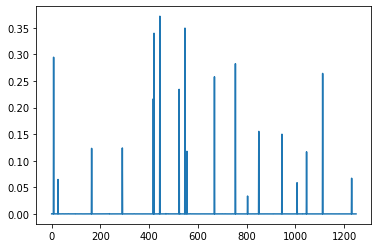

In [85]:
import matplotlib.pyplot as plt
plt.plot(range(0,len(loss_list_flip)), loss_list_flip[::])
plt.show()

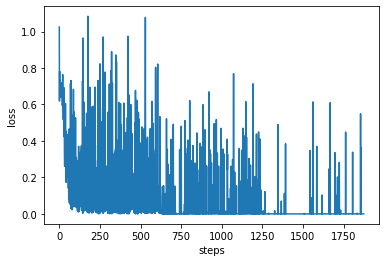

In [48]:
import matplotlib.pyplot as plt
plt.plot(range(0,len(loss_list)), loss_list[::])
plt.xlabel('steps')
plt.ylabel('loss')
plt.show()

In [25]:
# 在测试集上表现
get_accuracy(test_dataloader, model)

tensor(0.9690, device='cuda:0')

In [40]:
# 保存模型
import os

model_path = './model_save_69/'
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('./model_save_69/tokenizer_config.json',
 './model_save_69/special_tokens_map.json',
 './model_save_69/spiece.model',
 './model_save_69/added_tokens.json',
 './model_save_69/tokenizer.json')